[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Exploring PECD4.2 aggregated energy data for different Solar Photovoltaic technologies

In the following Notebook, we will explore the spatially aggregated data (CSV format) from one of the available energy indicators of the Pan-European Climate Database version 4.2 ([PECD4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)): the solar photovoltaic generation (SPV) at the PEON (PECD onshore regions) level. We will focus on comparing different SPV technologies, considering one year (2020) of data from the historical stream (1950 to present). Note that, in principle, the analyses could be extended to consider more years and also climate projections (2015-2100).

After downloading the needed data from the CDS, we will visualize it by generating two types of figures that will help us compare the different technologies:

*   bar plots: useful to visualize annual mean SPV generation values;

*   line plots: useful to visualize one or more time series;

*   histograms: useful to compare the distribution of low/high wind power generation values

All the code will be in Python.

## Learning objectives 🎯

Throughout this notebook, you will learn how to quickly download and read the PECD 4.2 CSV files and organize them into tables (DataFrames). You will also learn how to select a single column of your DataFrame (a single PECD region). You will learn how to produce a figure to show one or multiple time series, as well as a figure to visualize histograms to compare different SPV technologies.
Along the way, you'll get familiar with these technologies, as well as some key Python libraries that will be useful for more complex operations and/or visualizations with PECD4.2 data.

## Target Audience 🎯

**Anyone** interested in learning about different Solar PV technologies offered by the new version of the PECD (PECD4.2), and how to compare them.

## Prepare your environment


### Import required packages


We start by importing some useful libraries. These include: [os](https://docs.python.org/3/library/os.html), which provides a way to interact with the operating system and it is used here to manipulate paths; [pandas](https://pandas.pydata.org/), one of the most common and easy to use tools for data analysis and manipulation; [numpy](https://numpy.org/doc/stable/), fundamental for numerical computing; [matplotlib](https://matplotlib.org/), a standard library for creating visualizations in Python; [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) a service providing programmatic access to CDS that will allow you to download data for this analysis.

In [1]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.
Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes ```"your_api_key"```). Your token can be found on the [CDS portal](https://cds.climate.copernicus.eu/profile) (you will need to log in to see your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [2]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the needed data

The data can be downloaded from the PECD CDS download form, by ticking the boxes of interest. Once all the required information is manually selected, scroll to the bottom of the form and click on "Show API request". This will reveal a code block that can be copied and pasted directly into a cell of your Jupyter Notebook. This step has already been done for you in the cell below, but if you'd like to try it yourself, visit the [CDS download form](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download).

In this example, we use data from the PECD version 'PECD4.2' for the 'Historical' temporal stream (coming from 'ERA5 reanalysis' data). The selected variable is the 'Solar photovoltaic generation capacity factor', and the technologies included (and ticked in the form) are:
- Tech type 60: industrial rooftop
- Tech type 61: residential rooftop
- Tech type 62: utility-scale fixed
- Tech type 63: utility-scale tracking (1-axis)

The API request reflecting these selections is shown in the next cell.

In [3]:
# define our dataset
dataset = "sis-energy-pecd"

# dictionary of base request
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "variable": ["solar_photovoltaic_generation_capacity_factor"],
    "technology": [
        "60",
        "61",
        "62",
        "63"
    ],
    "spatial_resolution": ["peon"],
    "year": ["2020"]
}

Before running the download we can make sure there's a dedicated folder ready to host the data.

In [4]:
input_dir = "cds_data/spv_power"
os.system(f"mkdir -p {input_dir}")

0

Now that it is all set, we are ready to download the data.

In [5]:
# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/test.zip")

2025-07-14 08:32:07,884 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-14 08:32:17,701 INFO Request ID is 801e6860-a69e-45c3-89d5-68489e00b3b1
2025-07-14 08:32:17,760 INFO status has been updated to accepted
2025-07-14 08:32:26,098 INFO status has been updated to running
2025-07-14 08:32:38,834 INFO status has been updated to successful


9db98d90a6f52602fa85a1bf297d75e1.zip:   0%|          | 0.00/8.34M [00:00<?, ?B/s]

'cds_data/spv_power/test.zip'

Since our data are inside zipped files we need to unzip them. The final csv files will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) of the  PECD.

In [6]:
# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        os.system(f'unzip {input_dir}/{fname} -d {input_dir}')

Archive:  cds_data/spv_power/test.zip
  inflating: cds_data/spv_power/H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv  
  inflating: cds_data/spv_power/H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_61_NA---_NA---_PhM03_PECD4.2_fv1.csv  
  inflating: cds_data/spv_power/H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv  
  inflating: cds_data/spv_power/H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_63_NA---_NA---_PhM03_PECD4.2_fv1.csv  


## Load the data


Once the data is unzipped, it is ready to be loaded with Pandas: the analysis can begin!

In [7]:
# Load generation data for the different SPV technology types.
# tech type 60: industrial rooftop
file_name = ("H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300" +
             "_CFR_TIM_01h_COM_noc_org_60_NA---_NA---_PhM03_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, file_name)
df_roof_indu = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

# tech type 61: residential rooftop
file_name = ("H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300" +
             "_CFR_TIM_01h_COM_noc_org_61_NA---_NA---_PhM03_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, file_name)
df_roof_resi = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

# tech type 62: utility-scale fixed
file_name = ("H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300" +
             "_CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, file_name)
df_util_fixed = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

# tech type 63: utility-scale tracking
file_name = ("H_ERA5_ECMW_T639_SPV_0000m_Pecd_PEON_S202001010000_E202012312300" +
             "_CFR_TIM_01h_COM_noc_org_63_NA---_NA---_PhM03_PECD4.2_fv1.csv")
file_path = os.path.join(input_dir, file_name)
df_util_track = pd.read_csv(file_path, comment='#', index_col=['Date'], parse_dates=['Date'])

## Plot the data


Now that we have four DataFrames with all the information, we can start exploring the data by plotting some time series to see how solar photovoltaic generation differs between technologies.

### Plot the annual mean CFs (bar plot)


If we want to visualize the annual mean SPV capacity factors for a single region, we need to specify the region to plot. We here pick Central/Southern Italy, with code 'ITCS', plotting all four technologies together to compare them.
Please remember that the PECD4.2 data were downloaded just for one weather year (2020), but, in principle, the presented analyses can be extended to cover as many weather years as required: to have an idea on how to download and put together data from different years and models (e.g. reanalysis and climate projections), have a look at [Notebook *explore-csv-data.ipynb*](./explore-csv-data.ipynb).

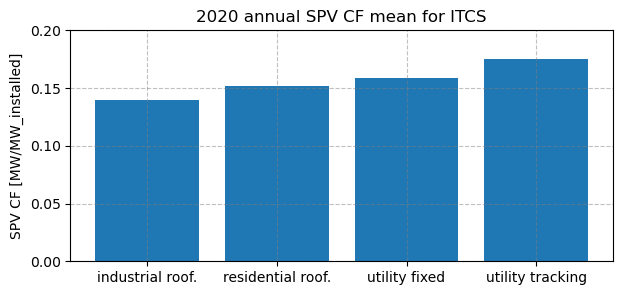

Industrial rooftops: 0.139
Residential rooftops: 0.152
Utility fixed: 0.158
Utility tracking: 0.175


In [8]:
# Plot mean value for 4 different SPV technologies for region ITCS (Central/Southern Italy)
region_to_plot = 'ITCS'

# Plot directory
plt_dir = 'results/windpower'
os.system(f"mkdir -p {plt_dir}")

annual_means = [
    df_roof_indu[region_to_plot].values.mean(),
    df_roof_resi[region_to_plot].values.mean(),
    df_util_fixed[region_to_plot].values.mean(),
    df_util_track[region_to_plot].values.mean()
]

# Labels
labels = ['industrial roof.', 'residential roof.', 'utility fixed', 'utility tracking']

# Plot
plt.figure(figsize=(7, 3))
plt.bar(labels, annual_means)
plt.title(f'2020 annual SPV CF mean for {region_to_plot}')
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.yticks(np.arange(0, 0.25, 0.05))
plt.ylabel('SPV CF [MW/MW_installed]')
plt.savefig(os.path.join(plt_dir, f'SPV_CF_{region_to_plot}_bars.png'), bbox_inches="tight")
plt.show()
plt.close()

print(f'Industrial rooftops: {df_roof_indu[region_to_plot].mean().round(3)}')
print(f'Residential rooftops: {df_roof_resi[region_to_plot].mean().round(3)}')
print(f'Utility fixed: {df_util_fixed[region_to_plot].mean().round(3)}')
print(f'Utility tracking: {df_util_track[region_to_plot].mean().round(3)}')

### Plot a time series (line plot)


You might also want to visualize the data as timeseries. To not overburden the visualization, only the utility fixed and tracking technologies are compared.

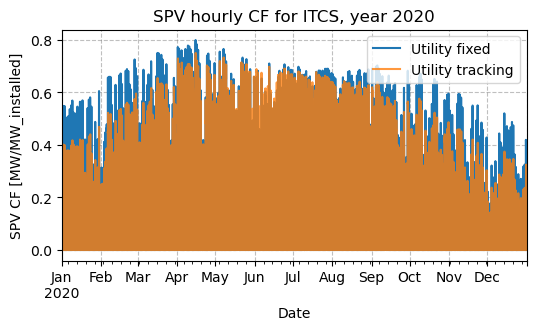

In [9]:
plt.figure(figsize=(6, 3))
df_util_fixed[region_to_plot].plot(label="Utility fixed")
df_util_track[region_to_plot].plot(label="Utility tracking", alpha=0.8)
plt.legend(loc="upper right")
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'SPV hourly CF for {region_to_plot}, year 2020')
plt.ylabel('SPV CF [MW/MW_installed]')
plt.savefig(os.path.join(plt_dir, f'SPV_CF_{region_to_plot}.png'), bbox_inches="tight")
plt.show()
plt.close()

### Plot a time series with zoom


Oddly enough, the tracking configuration seems to be consistently lower than the fixed one, despite the higher annual CF of the first. However, this is a visual artifact of this type of figure: if we try and zoom in on a few days, we'll notice why.

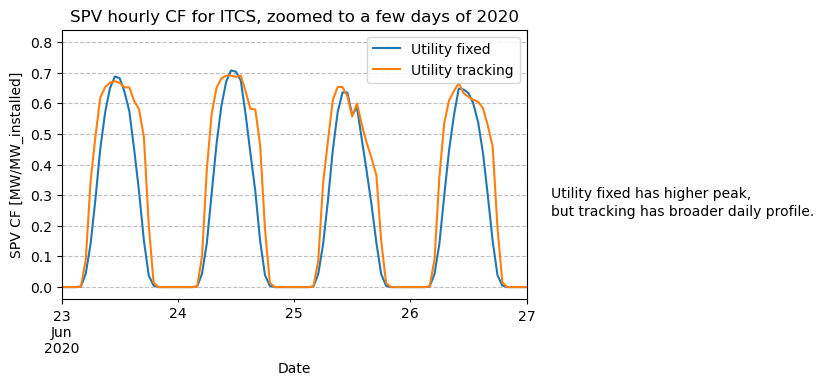

In [10]:
# Plot and zoom
fig, ax = plt.subplots(figsize=(6, 3.5))
df_util_fixed[region_to_plot].plot(ax=ax, label="Utility fixed")
df_util_track[region_to_plot].plot(ax=ax, label="Utility tracking")
plt.legend(loc="upper right")
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'SPV hourly CF for {region_to_plot}, zoomed to a few days of 2020')
plt.ylabel('SPV CF [MW/MW_installed]')

start_date = '2020-06-23'
end_date = '2020-06-27'

ax.set_xlim(start_date, end_date)

textstr = ['Utility fixed has higher peak,', 'but tracking has broader daily profile.']
for k in range(0, 2):
    plt.text(0.94, 0.4-k*0.05, textstr[k], transform=plt.gcf().transFigure)

plt.savefig(os.path.join(plt_dir, f'SPV_CF_{region_to_plot}_zoom.png'), bbox_inches="tight")
plt.show()
plt.close()

The zoomed plot shows that while fixed systems have higher peaks at noon, tracking produces broader daily profiles, something that an hourly full-year plot cannot show. Plotting the daily or monthly mean CF is more effective for visualizing the seasonality of each technology.

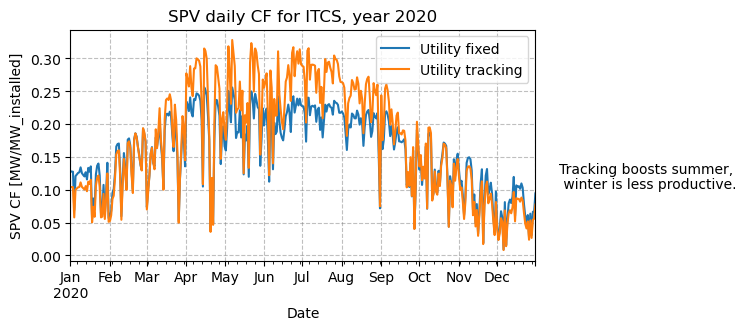

In [11]:
# Replace D by ME to get the equivalent monthly-level visualization
plt.figure(figsize=(6, 3))
df_util_fixed[region_to_plot].resample('D').mean().plot(label="Utility fixed")
df_util_track[region_to_plot].resample('D').mean().plot(label="Utility tracking")
plt.legend(loc="upper right")
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'SPV daily CF for {region_to_plot}, year 2020')
plt.ylabel('SPV CF [MW/MW_installed]')

textstr = ['Tracking boosts summer,', ' winter is less productive.']
for k in range(0, 2):
    plt.text(0.94, 0.4-k*0.05, textstr[k], transform=plt.gcf().transFigure)

plt.savefig(os.path.join(plt_dir, f'SPV_CF_{region_to_plot}_daily.png'), bbox_inches="tight")
plt.show()
plt.close()

### Plot histogram


Histograms are often used to get an overview of high/low generation distributions. They also provide interesting information when comparing different solar technologies.

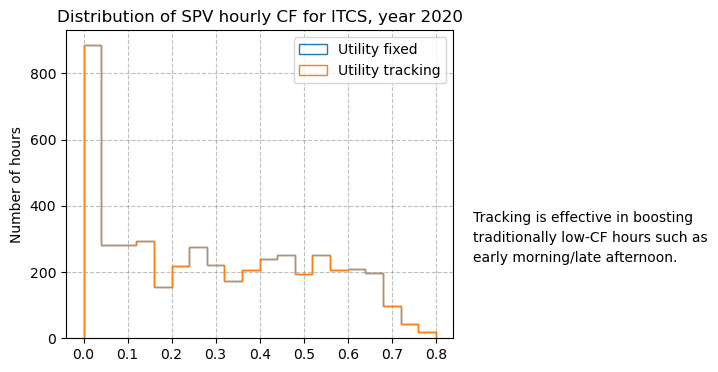

In [12]:
plt.figure(figsize=(5, 4))
# for a more insightful visualization, the night values were ignored in the analysis
df_day = df_util_fixed[df_util_fixed[region_to_plot] > 0]
df_day[region_to_plot].hist(label="Utility fixed", bins=20, histtype='step')
df_day[region_to_plot].hist(label="Utility tracking", bins=20, histtype='step')
plt.legend(loc="upper right")
plt.grid(color='gray', linestyle='--', alpha=0.5)
plt.title(f'Distribution of SPV hourly CF for {region_to_plot}, year 2020')
plt.ylabel('Number of hours')

textstr = ['Tracking is effective in boosting',
           'traditionally low-CF hours such as', 'early morning/late afternoon.']
for k in range(0, 3):
    plt.text(0.94, 0.4-k*0.05, textstr[k], transform=plt.gcf().transFigure)

plt.savefig(os.path.join(plt_dir, f'SPV_CF_{region_to_plot}_hist.png'), bbox_inches="tight")
plt.show()
plt.close()

The histogram is effective in giving a high-level overview of the CF going beyond the annual mean value.

## Take home messages 📌


*   Energy data stored in CSV files can be easily read, explored, and summarized using pandas.
*   Time series can be plotted using matplotlib for visual comparison, and it's simple to zoom in on a specific time window.
*   PECD4.2 SPV data comprises several technologies
*   Histograms and annual capacity factors can help in comparing the different solar PV technologies.
*   Annual mean capacity factors can be represented through bar plots, which are easy to produce.